## 


In [1]:
import os
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = 'drive/My Drive/TSECC_datathon2020'
datas = pd.read_csv(os.path.join(path, "data/data_full.csv"), encoding="utf-8")
# drop the last 3 rows because no outcome label
datas = datas[:-3]

In [4]:
datas.loc[datas['age'] > 91,'age'] = 91
datas['age'].value_counts()

91.000000    40752
43.208354     1127
58.221245     1033
27.066079      917
53.910612      877
             ...  
19.704060        4
66.826551        4
87.277255        3
84.968002        2
81.182024        1
Name: age, Length: 7852, dtype: int64

In [5]:
datas_0 = datas[datas['outcome_3h_ahead'] == 0]
datas_1 = datas[datas['outcome_3h_ahead'] == 1]
print(len(datas_0)), print(len(datas_1))

980457
76389


(None, None)

In [6]:
# train
#datas = pd.concat([datas[datas['outcome_3h_ahead'] == 0].head(50000), datas[datas['outcome_3h_ahead'] == 1].head(50000)])
datas = pd.concat([datas[datas['outcome_3h_ahead'] == 0].head(30000), datas[datas['outcome_3h_ahead'] == 1].head(30000)])

In [7]:
label = datas['outcome_3h_ahead']
datas = datas.drop(['outcome_3h_ahead'], axis=1)
# datas['outcome_3h_ahead'] = label
datas

,lactate,rdw,hct,bili_d,plt,inr,alt,wbc,hb,crtn,alkp,bun,potassium,m_ap,systolic_bp,diastolic_bp,hr,temperature,rr,sao2,fio2,gcs,sofa,age
0,NaN,14.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.0,122.0,72.0,91.5,33.055556,16.0,89.0,100.0,15,4,70.767678
1,NaN,14.8,36.3,NaN,174.0,1.2,NaN,15.3,12.7,0.9,NaN,19.0,4.2,84.0,137.0,70.0,89.0,31.666667,13.0,93.0,NaN,15,4,70.767678
2,NaN,14.8,36.3,NaN,174.0,1.2,NaN,15.3,12.7,0.9,NaN,19.0,4.2,98.0,139.0,84.0,87.0,30.555556,22.0,95.0,NaN,15,4,70.767678
3,NaN,14.8,36.3,NaN,174.0,1.2,NaN,15.3,12.7,0.9,NaN,19.0,4.2,89.0,118.0,82.0,80.0,26.666667,15.0,96.0,NaN,15,4,70.767678
4,1.0,14.8,36.3,NaN,174.0,1.2,NaN,15.3,12.7,0.9,NaN,19.0,4.2,95.0,134.0,83.0,83.0,28.333333,20.0,91.0,NaN,15,4,70.767678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418369,1.2,18.4,28.8,NaN,189.0,2.5,NaN,13.2,8.9,1.5,NaN,11.0,4.8,55.0,94.0,42.0,70.0,21.111111,20.0,100.0,NaN,15,5,80.628706
418370,1.2,18.4,28.8,NaN,189.0,2.5,NaN,13.2,8.9,1.5,NaN,11.0,4.8,56.5,84.5,48.0,70.0,21.111111,16.0,100.0,NaN,15,5,80.628706
418372,1.2,18.4,28.8,NaN,189.0,2.5,NaN,13.2,8.9,1.5,NaN,11.0,4.6,53.0,98.0,44.0,70.0,21.111111,14.0,100.0,NaN,15,5,80.628706
418373,1.2,18.4,28.8,NaN,189.0,2.5,NaN,13.2,8.9,1.5,NaN,11.0,4.6,64.0,89.0,56.0,70.0,21.111111,15.0,99.0,NaN,15,5,80.628706


In [8]:
# s = datas.isna().sum()
# s[s > 0], s

In [9]:
label[label.isna()]

Series([], Name: outcome_3h_ahead, dtype: float64)

In [10]:
# 補缺失值
# for col in s[s > 0].index:
#     most = datas[col].value_counts().idxmax()
#     datas[col] = datas[col].fillna(most)

datas = datas.fillna(datas.mean())
# datas.isna().sum()

In [11]:
label = label.fillna(0)
label.isna().sum()   

0

In [12]:
# pd.concat([datas,label]).to_csv("data_full_fillna.csv", encoding="utf-8", index=False)

In [13]:
# one-hot encoding
# datas = pd.get_dummies(datas)

In [14]:
# Normalization
scaler = MinMaxScaler()
datas_scale = pd.DataFrame(scaler.fit_transform(datas), columns=datas.columns)
datas_scale

,lactate,rdw,hct,bili_d,plt,inr,alt,wbc,hb,crtn,alkp,bun,potassium,m_ap,systolic_bp,diastolic_bp,hr,temperature,rr,sao2,fio2,gcs,sofa,age
0,0.053181,0.168224,0.522766,0.086225,0.159503,0.039649,0.006882,0.025686,0.538983,0.011849,0.048155,0.138330,0.023749,0.262069,0.460377,0.000681,0.008865,0.008865,0.029091,0.89,1.000000,1.0,0.222222,0.722514
1,0.053181,0.168224,0.648214,0.086225,0.125093,0.019048,0.006882,0.033074,0.709497,0.005660,0.048155,0.074689,0.025109,0.262069,0.516981,0.000659,0.008486,0.008486,0.023636,0.93,0.511262,1.0,0.222222,0.722514
2,0.053181,0.168224,0.648214,0.086225,0.125093,0.019048,0.006882,0.033074,0.709497,0.005660,0.048155,0.074689,0.025109,0.310345,0.524528,0.000812,0.008183,0.008183,0.040000,0.95,0.511262,1.0,0.222222,0.722514
3,0.053181,0.168224,0.648214,0.086225,0.125093,0.019048,0.006882,0.033074,0.709497,0.005660,0.048155,0.074689,0.025109,0.279310,0.445283,0.000790,0.007122,0.007122,0.027273,0.96,0.511262,1.0,0.222222,0.722514
4,0.024291,0.168224,0.648214,0.086225,0.125093,0.019048,0.006882,0.033074,0.709497,0.005660,0.048155,0.074689,0.025109,0.300000,0.505660,0.000801,0.007577,0.007577,0.036364,0.91,0.511262,1.0,0.222222,0.722514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.032389,0.336449,0.514286,0.086225,0.136195,0.080952,0.006882,0.028534,0.497207,0.009434,0.048155,0.041494,0.031659,0.162069,0.354717,0.000351,0.005607,0.005607,0.036364,1.00,0.511262,1.0,0.277778,0.857758
59996,0.032389,0.336449,0.514286,0.086225,0.136195,0.080952,0.006882,0.028534,0.497207,0.009434,0.048155,0.041494,0.031659,0.167241,0.318868,0.000417,0.005607,0.005607,0.029091,1.00,0.511262,1.0,0.277778,0.857758
59997,0.032389,0.336449,0.514286,0.086225,0.136195,0.080952,0.006882,0.028534,0.497207,0.009434,0.048155,0.041494,0.029476,0.155172,0.369811,0.000373,0.005607,0.005607,0.025455,1.00,0.511262,1.0,0.277778,0.857758
59998,0.032389,0.336449,0.514286,0.086225,0.136195,0.080952,0.006882,0.028534,0.497207,0.009434,0.048155,0.041494,0.029476,0.193103,0.335849,0.000505,0.005607,0.005607,0.027273,0.99,0.511262,1.0,0.277778,0.857758


In [15]:
# prepare predict data
data_pred = pd.concat([datas_0[-100:], datas_1[-100:]])
data_pred_y = data_pred['outcome_3h_ahead']
data_pred_x = data_pred.drop(['outcome_3h_ahead'], axis=1)
data_pred_x = data_pred_x.fillna(datas.mean())
data_pred_y = data_pred_y.fillna(0)
#data_pred_x.isna().sum(), data_pred_y.isna().sum()

scaler = MinMaxScaler()
data_pred_x = pd.DataFrame(scaler.fit_transform(data_pred_x), columns=data_pred_x.columns)
data_pred_x

,lactate,rdw,hct,bili_d,plt,inr,alt,wbc,hb,crtn,alkp,bun,potassium,m_ap,systolic_bp,diastolic_bp,hr,temperature,rr,sao2,fio2,gcs,sofa,age
0,0.133333,0.355769,0.500000,0.635411,0.802367,0.1,0.395833,0.948598,0.481481,0.058824,0.658163,0.139535,0.305556,0.363636,0.462264,0.429967,0.716418,0.716418,0.56250,1.0000,0.730374,1.0,0.000000,0.155227
1,0.133333,0.355769,0.500000,0.635411,0.802367,0.1,0.395833,0.948598,0.481481,0.058824,0.658163,0.139535,0.305556,0.351515,0.500000,0.364821,0.656716,0.656716,0.46875,0.8125,0.730374,1.0,0.333333,0.155227
2,0.133333,0.355769,0.500000,0.635411,0.802367,0.1,0.395833,0.948598,0.481481,0.058824,0.658163,0.139535,0.305556,0.448485,0.490566,0.547231,0.776119,0.776119,0.78125,0.8125,0.730374,1.0,0.333333,0.155227
3,0.133333,0.355769,0.500000,0.635411,0.802367,0.1,0.395833,0.948598,0.481481,0.058824,0.658163,0.139535,0.305556,0.351515,0.405660,0.416938,0.716418,0.716418,0.75000,0.8125,0.730374,1.0,0.444444,0.155227
4,0.133333,0.355769,0.500000,0.635411,0.802367,0.1,0.395833,0.948598,0.481481,0.058824,0.658163,0.139535,0.305556,0.254545,0.245283,0.364821,0.582090,0.582090,0.53125,0.8125,0.730374,1.0,0.444444,0.155227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.133333,0.153846,0.566116,0.635411,0.397633,0.1,0.562500,0.742991,0.530864,0.088235,0.877551,0.127907,0.277778,0.242424,0.281822,0.299674,0.432836,0.432836,0.31250,0.9375,0.730374,1.0,0.111111,0.155227
196,0.133333,0.182692,0.500000,0.635411,0.480473,0.1,0.708333,0.892523,0.506173,0.058824,0.964286,0.139535,0.277778,0.303030,0.281822,0.377850,0.432836,0.432836,0.34375,0.9375,0.571429,1.0,0.000000,0.155227
197,0.133333,0.182692,0.500000,0.635411,0.480473,0.1,0.708333,0.892523,0.506173,0.058824,0.964286,0.139535,0.277778,0.218182,0.281822,0.351792,0.417910,0.417910,0.31250,0.8125,0.730374,1.0,0.111111,0.155227
198,0.133333,0.182692,0.500000,0.635411,0.480473,0.1,0.708333,0.892523,0.506173,0.058824,0.964286,0.139535,0.277778,0.278788,0.281822,0.416938,0.552239,0.552239,0.34375,0.8750,0.730374,1.0,0.555556,0.155227


In [16]:
# 切分訓練data
# x_train, x_test, y_train, y_test = train_test_split(np.array(datas_scale.iloc[:,:-1]), np.array(datas_scale.iloc[:,-1]), test_size=0.2, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(np.array(datas_scale), np.array(label), test_size=0.2, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((48000, 24), (12000, 24), (48000,), (12000,))

In [17]:
y_train[:50]

array([0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.])

In [18]:
def build_mlp(input_shape, output_units=1, num_neurons=[4096, 512, 32], l1_p=1e-8, l2_p=1e-12, drp_ratio=0., BN=True):
    """
    建立神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_p, l2=l2_p))(input_layer)
            if BN == True:
                x = BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1),
                                  kernel_regularizer=l1_l2(l1=l1_p, l2=l2_p))(x)
            if BN == True:
                x = BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="sigmoid", name="output")(x)
    #out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [19]:
"""
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 500
BATCH_SIZE = 16
MOMENTUM = 0.95

In [20]:
"""
設定 callbacks: Earlystop
"""
#earlystop = EarlyStopping(monitor="val_accuracy", patience=20, verbose=1)
earlystop = EarlyStopping(monitor="val_loss", patience=10, verbose=1)
checkpoint = ModelCheckpoint(os.path.join(path,"sepsis_dl.h5"), save_best_only=True, save_weights_only=False)
reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

In [21]:
x_train.shape

(48000, 24)

In [22]:
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([24003, 23997]))

In [23]:
# 計算  class_weight
data_count = np.unique(y_train, return_counts=True)[1]
print(data_count)
num_classes=2
c_weights = (1/data_count)*np.sum(data_count)/num_classes
print(c_weights)
class_weight = {i: w for i, w in enumerate(c_weights)}
print('class_weight', class_weight)

[24003 23997]
[0.99987502 1.00012502]
class_weight {0: 0.9998750156230471, 1: 1.0001250156269534}


In [25]:
# 建立模型
model = build_mlp(input_shape=x_train.shape[1:], l1_p=1e-4, l2_p=1e-6, drp_ratio=0.3)
model.summary()
#optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=optimizer)
#model.compile(loss="categorial_crossentropy", metrics=["accuracy"], optimizer=optimizer)

# load pre-trained model
model = keras.models.load_model(os.path.join(path,"sepsis_dl.h5"))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 4096)              102400    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
re_lu (ReLU)                 (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               2097664   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)              

In [26]:

"""
訓練流程, 並將結果用 dictionary 紀錄
"""

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          class_weight = class_weight,
          callbacks=[checkpoint, earlystop, reduce_lr],
          verbose=2
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]


Epoch 1/500
3000/3000 - 72s - loss: 0.5143 - accuracy: 0.7603 - val_loss: 0.4322 - val_accuracy: 0.8217
Epoch 2/500
3000/3000 - 72s - loss: 0.5200 - accuracy: 0.7556 - val_loss: 0.4302 - val_accuracy: 0.8216
Epoch 3/500
3000/3000 - 70s - loss: 0.5186 - accuracy: 0.7585 - val_loss: 0.4305 - val_accuracy: 0.8201
Epoch 4/500
3000/3000 - 69s - loss: 0.5157 - accuracy: 0.7614 - val_loss: 0.4308 - val_accuracy: 0.8226
Epoch 5/500
3000/3000 - 69s - loss: 0.5174 - accuracy: 0.7584 - val_loss: 0.4311 - val_accuracy: 0.8221
Epoch 6/500
3000/3000 - 69s - loss: 0.5161 - accuracy: 0.7585 - val_loss: 0.4317 - val_accuracy: 0.8213
Epoch 7/500

Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
3000/3000 - 73s - loss: 0.5143 - accuracy: 0.7624 - val_loss: 0.4307 - val_accuracy: 0.8224
Epoch 8/500
3000/3000 - 68s - loss: 0.5114 - accuracy: 0.7643 - val_loss: 0.4314 - val_accuracy: 0.8223
Epoch 9/500
3000/3000 - 69s - loss: 0.5168 - accuracy: 0.7591 - val_loss: 0.4288 - val_

In [27]:
history_df = pd.DataFrame(model.history.history)
with open(os.path.join(path,"dnn_history.json"), mode='w') as f:
    history_df.to_json(f)

In [28]:
len(train_loss), len(valid_loss), len(train_acc), len(valid_acc)

(24, 24, 24, 24)

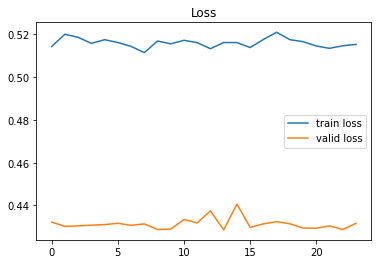

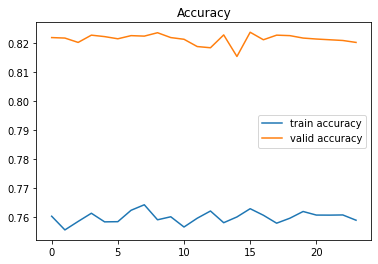

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
將結果繪出
"""
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

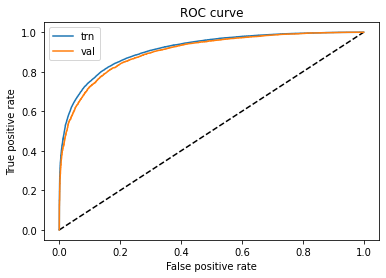

In [30]:
# ROC curve
pred_proba_train = model.predict(x_train)[:,0]
fpr_trn, tpr_trn, _ = metrics.roc_curve(y_train, pred_proba_train)

pred_proba = model.predict(x_test)[:,0]
fpr, tpr, _ = metrics.roc_curve(y_test, pred_proba)

# 將結果繪圖
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_trn, tpr_trn, label='trn')
plt.plot(fpr, tpr, label='val')


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [31]:
# auc score 
auc_train = metrics.roc_auc_score(y_train, model.predict(x_train)[:,0])
auc_test = metrics.roc_auc_score(y_test, model.predict(x_test)[:,0])
print("AUC of: train={} test={} ".format(auc_train, auc_test))

AUC of: train=0.91302016270344 test=0.9023995589332232 


In [32]:
data_pred_x.shape, data_pred_y.shape

((200, 24), (200,))

In [33]:
model.predict(data_pred_x).shape

(200, 1)

In [34]:
y_pre = model.predict(np.array(data_pred_x))[:,0] > 0.5
y_pre

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,

In [35]:
from sklearn.metrics import classification_report

target_names = [str(i) for i in range(2)]
print(classification_report(np.array(data_pred_y), np.array(y_pre), target_names=target_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.49      0.95      0.64       100

    accuracy                           0.48       200
   macro avg       0.24      0.47      0.32       200
weighted avg       0.24      0.47      0.32       200



In [36]:
pd.DataFrame(metrics.confusion_matrix(np.array(data_pred_y), np.array(y_pre)),
            index=["{}(真實)".format(i) for i in range(2)],
            columns=["{}(預測)".format(i) for i in range(2)] 
            )

,0(預測),1(預測)
0(真實),0,100
1(真實),5,95


In [ ]:
# ! pip install eli5

In [ ]:
# import eli5
# from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(model, random_state=0).fit(x_test, y_test)
# eli5.show_weights(perm, feature_names = x_test.columns.tolist())

In [37]:
! pip install shap

     |████████████████████████████████| 327kB 12.2MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463915 sha256=190c2011c69af1cf90168822b65aade633102429b479c19c6641fc0c79d35268
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [38]:
import sklearn
import shap

# print the JS visualization code to the notebook
shap.initjs()

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model.predict, shap.sample(x_train, 2))
x_train_df = pd.DataFrame(x_train, columns=datas.columns)
shap_values = explainer.shap_values(x_train_df, nsamples=100)


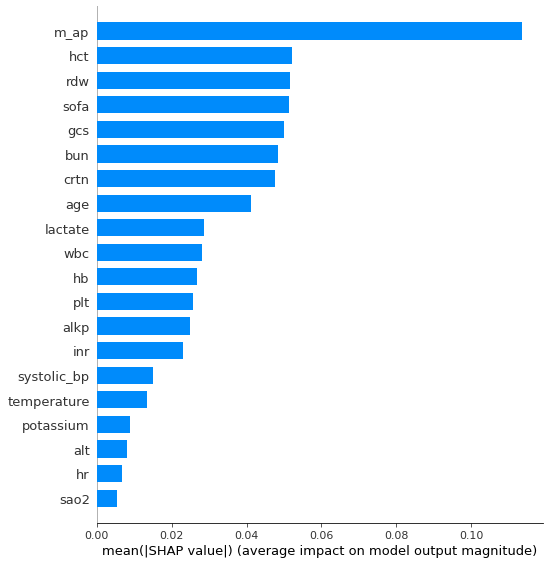

In [39]:
# plot the SHAP values for the Setosa output of the first instance
#  shap.force_plot(explainer.expected_value[0], shap_values[0], data_pred_x, link="logit")
shap.summary_plot(shap_values[0], x_train_df, plot_type="bar")

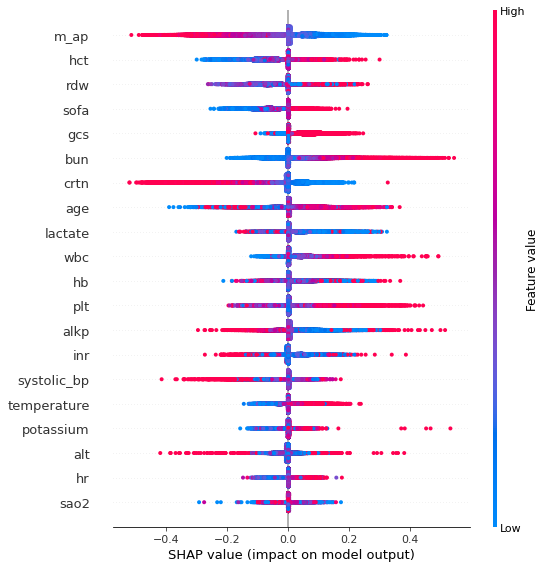

In [41]:
shap.summary_plot(shap_values[0], x_train_df)

In [ ]:
shap_values[0].shape